# 참고자료
- 머신러닝 접근 Basic (Feature ~ Pycaret, CatBoost) https://dacon.io/competitions/official/235745/codeshare/2958?page=1&dtype=recent
- 주차수요 예측 EDA & Catboost Baseline https://dacon.io/competitions/official/235745/codeshare/2851?page=1&dtype=recent  
- warm start를 위한 간단한 Data Understanding(EDA) 공유 https://dacon.io/competitions/official/235745/codeshare/2853?page=1&dtype=recent

# 목차

## 0. Library
## 1. Data Loading
## 2. EDA
## 3. Feature Engineering
### 3-1. Feature Generation
### 3-2. Feature Engineering
### 3-2-1. Encoding
### 3-2-2. Scailing
## 4. Modeling with Pycaret
## 5. Modeling with CatBoostRegressor

In [1]:
# 임대주택 단지 내 적정 주차수요 예측 대회

# [배경]

# 아파트 단지 내 필요한 주차대수는 ①법정주차대수 ②장래주차수요 중 큰 값에 따라 결정하게되어 있어, 
# 정확한 ②장래주차수요의 산정을 필요로 합니다.
# 현재 ②장래주차수요는 ‘주차원단위’와 ‘건축연면적’을 기초로하여 산출되고 있으며,
# ‘주차원단위’는 신규 건축예정 부지 인근의 유사 단지를 피크 시간대 방문하여 주차된 차량대수를 세는 방법으로 조사하고 있습니다.
# 이 경우 인력조사로 인한 오차발생, 현장조사 시점과 실제 건축시점과의 시간차 등의 문제로 과대 또는 과소 산정의 가능성을 배제할 수 없습니다.

# [주제] 유형별 임대주택 설계 시 단지 내 적정 주차 수요를 예측

# [평가]

# 평가산식 : MAE(Mean Absolute Error)
# Public 평가 : 전체 Test 데이터 중 무작위 33% (50단지)
# Private 평가 : 전체 Test 데이터 중 나머지 67% (100단지)
# [외부 데이터 및 사전학습 모델]

# 공공 데이터와 같이 누구나 얻을 수 있고 법적 제약이 없는 외부 데이터 허용
# 사전학습 모델의 경우 사전학습에 사용된 데이터를 명시해야함
# 최종 평가시 외부데이터 및 출처 제출
# Data Understanding
# train.csv - 학습용 데이터

# 단지코드(key)
# 총세대수
# 임대건물구분
# 지역
# 공급유형
# 전용면적
# 전용면적별세대수
# 공가수: 빈집
# 자격유형: 임차를 할 수 있는 자격 요건
# 임대료보증금
# 임대료
# 도보 10분거리 내 지하철역 수(환승노선 수 반영)
# 도보 10분거리 내 버스정류장 수
# 단지내주차면수
# 등록차량수(target)
# age_gender_info.csv - 지역 임대주택 나이별, 성별 인구 분포

# 지역
# 10대미만(여자)
# 10대미만(남자)
# 20대(여자)
# 20대(남자)
# 30대(여자)
# 30대(남자)
# 40대(여자)
# 40대(남자)
# 50대(여자)
# 50대(남자)
# 60대(여자)
# 60대(남자)
# 70대(여자)
# 70대(남자)
# 80대(여자)
# 80대(남자)
# 90대(여자)
# 90대(남자)
# 100대(여자)
# 100대(남자)

# 0. Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# 한글폰트 설정, 그래프 마이너스 표시 설정
import matplotlib
from matplotlib import font_manager, rc
from matplotlib import pyplot as plt
import platform
import seaborn as sns

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

from sklearn.preprocessing import RobustScaler, StandardScaler
# 1. StandardScaler : 기본 스케일. 평균과 표준편차 사용
# 평균을 제거하고 데이터를 단위 분산으로 조정한다. 
# 그러나 이상치가 있다면 평균과 표준편차에 영향을 미쳐 변환된 데이터의 확산은 매우 달라지게 된다.
# 따라서 이상치가 있는 경우 균형 잡힌 척도를 보장할 수 없다.

# 2. RobustScaler : 중앙값(median)과 IQR(interquartile range) 사용. 아웃라이어의 영향을 최소화
# 아웃라이어의 영향을 최소화한 기법이다. 중앙값(median)과 IQR(interquartile range)을 
# 사용하기 때문에 StandardScaler와 비교해보면 표준화 후 동일한 값을 더 넓게 분포 시킴.


from pycaret.regression import *
# for Modeling with Pycaret"
# Pycaret : pycaret이란 AutoML을 하게 해주는 파이썬 라이브러리입니다. 
# scikit-learn 패키지를 기반으로 하고 있으며 Classification, Regression, Clustering, Anomaly Detection 등등 다양한 모델을 지원합니다.  
# https://minimin2.tistory.com/137


from catboost import CatBoostRegressor
# for Modeling with CatBoostRegressor"
# CatBoost의 장점
# 1. 높은 예측 성능
# 2. 범주형 변수를 자동으로 전처리
# 3. 모델 튜닝이 간소화 (범주형 변수를 자동으로 전처리 해주니깐 그 부분에 대해서 따로 튜닝을 할 필요x)
# https://gentlej90.tistory.com/100


import optuna
from optuna import Trial
from optuna.samplers import TPESampler
# optuna : 하이퍼 파라미터 최적화 프레임워크, 파라미터의 범위를 지정, 
# 파라미터가 될 수 있는 목록 설정하면 trial 마다 파라미터를 변경하면서 
# 최적의 파라미터를 찾음


from sklearn.metrics import mean_absolute_error 
# Mean Absolute Error (MAE) : 모델의 예측값과 실제값의 차이를 모두 더한다는 개념


from sklearn.model_selection import train_test_split, StratifiedKFold

# 1. Data Loading

In [4]:
age_gender = pd.read_csv('data/age_gender_info.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submission.csv')

# 2. EDA

In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
총세대수,2952.0,886.661247,513.540168,26.00,513.50,779.00,1106.0000,2568.0
전용면적,2952.0,44.757215,31.874280,12.62,32.10,39.93,51.5625,583.4
전용면적별세대수,2952.0,102.747967,132.640159,1.00,14.00,60.00,144.0000,1865.0
공가수,2952.0,12.921070,10.778831,0.00,4.00,11.00,20.0000,55.0
도보 10분거리 내 지하철역 수(환승노선 수 반영),2741.0,0.176578,0.427408,0.00,0.00,0.00,0.0000,3.0
도보 10분거리 내 버스정류장 수,2948.0,3.695726,2.644665,0.00,2.00,3.00,4.0000,20.0
단지내주차면수,2952.0,601.668360,396.407072,13.00,279.25,517.00,823.0000,1798.0
등록차량수,2952.0,559.768293,433.375027,13.00,220.00,487.00,770.0000,2550.0


In [6]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
총세대수,1022.0,862.080235,536.340894,75.00,488.000,745.00,1161.0,2572.0
전용면적,1022.0,43.706311,35.890759,9.96,33.135,39.72,47.4,583.4
전용면적별세대수,1022.0,100.414873,125.997855,1.00,14.000,60.00,140.0,1341.0
공가수,1022.0,15.544031,11.070140,0.00,6.000,15.00,23.0,45.0
도보 10분거리 내 지하철역 수(환승노선 수 반영),980.0,0.136735,0.435500,0.00,0.000,0.00,0.0,2.0
도보 10분거리 내 버스정류장 수,1022.0,4.626223,5.414568,1.00,2.000,3.00,5.0,50.0
단지내주차면수,1022.0,548.771037,342.636703,29.00,286.000,458.00,711.0,1696.0


In [7]:
# 데이터 형태 확인
train.shape, test.shape, age_gender.shape, 

((2952, 15), (1022, 14), (16, 23))

In [8]:
# train, test 각 열의 고유 value 개수, 공통 value 개수, 차이 value 개수 확인용 함수 작성
def check_train_test_column_values(train, test, column):
    # 함수 정의: 두 데이터 테이블과 특정 컬럼을 집어 넣으면 value를 비교하여 출력하는 함수
    print("{} Column에 대한 train_test_values_check 입니다=======================".format(column))
    # Train/Test set의 입력 칼럼의 value를 set으로 받아줍니다.
    train_colset = set(train[column])
    test_colset  = set(test[column])

    # Train/Test-set 고유한 value의 개수를 구함.
    print(f"Train-set에 있는 고유한 value 개수 : {len(train_colset)}")
    print(f"Test-set에 있는 고유한 value 개수 : {len(test_colset)}")

    # Train/Test-set 모두에 포함되어있는 value를 구함.
    print('='* 80)
    common_colset = train_colset.intersection(test_colset)
    print(f"Train/Test-set에 공통으로 포함되어 있는 value 개수 : {len(common_colset)}")
    if len(common_colset) > 100: # value가 너무 많으면 어차피 보기 힘드므로 출력을 pass 합니다
        pass
    else:
        try: # int나 float은 sorted가 먹지 않기 때문에 try except로 넣어줍니다.
            print(f"Train/Test-set에 공통으로 포함되어 있는 value : {sorted(common_colset)}")
        except:
            print(f"Train/Test-set에 공통으로 포함되어 있는 value : {(common_colset)}")

    # Train-set에만 있는 value를 구함.
    print('='* 80)
    train_only_colset = train_colset.difference(test_colset)
    print(f"Train-set에만 있는 value는 총 {len(train_only_colset)} 개 입니다.")
    if len(train_only_colset) > 100:
        pass
    else:
        try:
            print(f"Train-set에만 있는 value는 : {sorted(train_only_colset)}")
        except:
            print(f"Train-set에만 있는 value는 : {(train_only_colset)}")

    # Test-set에만 있는 value를 구함.
    print('='* 80)
    test_only_colset = test_colset.difference(train_colset)
    print(f"Test-set에만 있는 value는 총 {len(test_only_colset)} 개 입니다.")
    if len(test_only_colset) > 100:
        pass
    else:
        try:
            print(f"Test-set에만 있는 value는 : {sorted(test_only_colset)}")
        except:
            print(f"Test-set에만 있는 value는 : {(test_only_colset)}")
    print(" ")

In [9]:
# train, test 열 데이터의 고유 value 개수, 공통 value, 고유 value 확인

obj_cols = []
for col in train.columns:
    if train[col].dtypes == 'object':
        obj_cols.append(col)
for col in obj_cols:
    check_train_test_column_values(train, test, col)
    


단지코드 Column에 대한 train_test_values_check 입니다=======================
Train-set에 있는 고유한 value 개수 : 423
Test-set에 있는 고유한 value 개수 : 150
Train/Test-set에 공통으로 포함되어 있는 value 개수 : 0
Train/Test-set에 공통으로 포함되어 있는 value : []
Train-set에만 있는 value는 총 423 개 입니다.
Test-set에만 있는 value는 총 150 개 입니다.
 
임대건물구분 Column에 대한 train_test_values_check 입니다=======================
Train-set에 있는 고유한 value 개수 : 2
Test-set에 있는 고유한 value 개수 : 2
Train/Test-set에 공통으로 포함되어 있는 value 개수 : 2
Train/Test-set에 공통으로 포함되어 있는 value : ['상가', '아파트']
Train-set에만 있는 value는 총 0 개 입니다.
Train-set에만 있는 value는 : []
Test-set에만 있는 value는 총 0 개 입니다.
Test-set에만 있는 value는 : []
 
지역 Column에 대한 train_test_values_check 입니다=======================
Train-set에 있는 고유한 value 개수 : 16
Test-set에 있는 고유한 value 개수 : 15
Train/Test-set에 공통으로 포함되어 있는 value 개수 : 15
Train/Test-set에 공통으로 포함되어 있는 value : ['강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도']
Train-set에만 있는 value는 총 1 개 입니다.
T

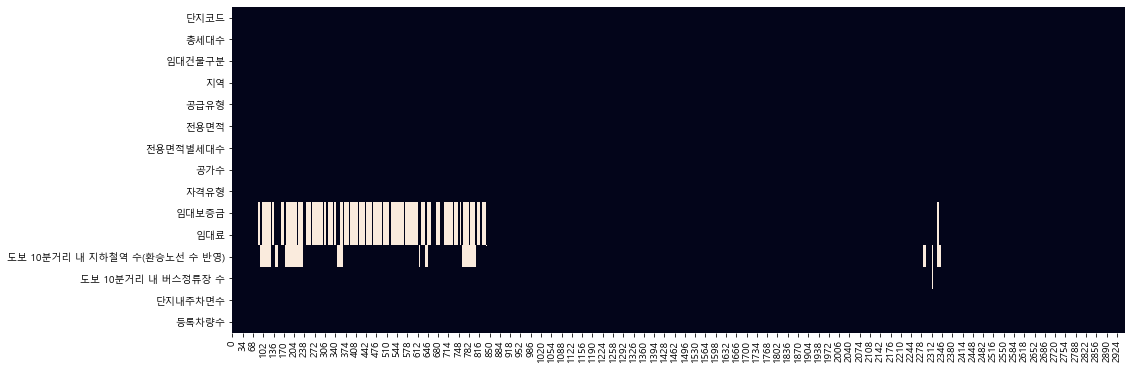

In [10]:
# 결측치 확인
plt.figure(figsize=(16, 6))
sns.heatmap(train.isnull().T, cbar=False)
plt.show()

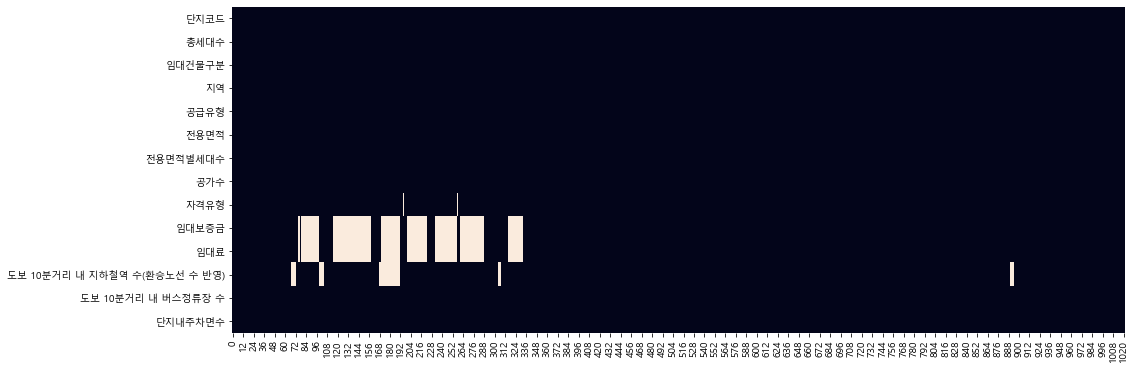

In [11]:
# 결측치 확인
plt.figure(figsize=(16, 6))
sns.heatmap(test.isnull().T, cbar=False)
plt.show()

In [12]:
train.isnull().sum().to_frame()

,0
단지코드,0
총세대수,0
임대건물구분,0
지역,0
공급유형,0
전용면적,0
전용면적별세대수,0
공가수,0
자격유형,0
임대보증금,569


In [13]:
test.isnull().sum().to_frame()

,0
단지코드,0
총세대수,0
임대건물구분,0
지역,0
공급유형,0
전용면적,0
전용면적별세대수,0
공가수,0
자격유형,2
임대보증금,180


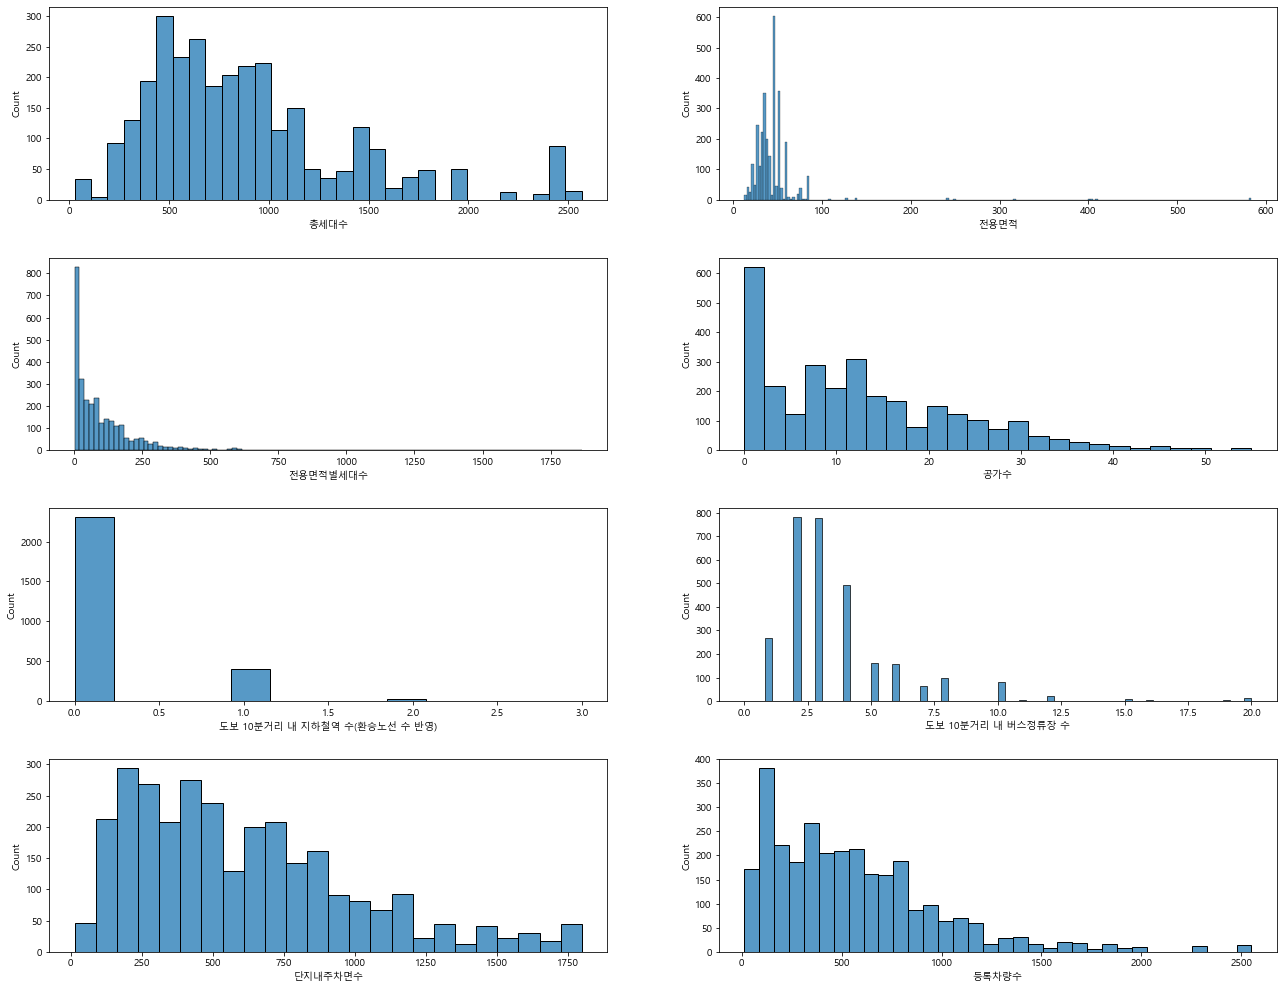

In [14]:
# 변수별 분포 확인
numeric_cols = []
for col in train.columns:
    if train[col].dtypes != 'object':
        numeric_cols.append(col)
fig = plt.figure(figsize=(22, 22))
for i, n in enumerate(numeric_cols):
    plt.subplot(5, 2, i+1)
    plt.subplots_adjust(hspace=0.3)
    sns.histplot(train[n])
    
# 전용면적, 전용면적별세대수 컬럼은 매우 skew한 분포를 띄고 있습니다.
# 총세대수, 단지내주차면서, 등록차량수 컬럼 또한 꼬리에서 튀어오르고 있습니다.
# 아웃라이어라고 할 수 있는 대단지가 존재하는 것으로 보입니다.
# 지하철 0 값이 대부분임을 확인

In [15]:
# test 자격유형 null 값 확인
test[test.자격유형.isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0


In [16]:
test[test.단지코드=='C2411'] # 단지코드로 봤을 때 A로 채우면 될 것으로 보임

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000,100720,0.0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000,100720,0.0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000,100720,0.0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000,171480,0.0,2.0,840.0


In [17]:
test[test.단지코드=='C2253'].head() # 단지코드로 봤을 때 C로 채우면 될 것으로 보임

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000,83020,0.0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000,83020,0.0,2.0,173.0
261,C2253,1161,상가,강원도,임대상가,13.77,1,0.0,D,NaN,NaN,0.0,2.0,173.0
262,C2253,1161,상가,강원도,임대상가,22.89,1,0.0,D,NaN,NaN,0.0,2.0,173.0


In [18]:
# 중복 확인
train.shape, train.drop_duplicates().shape # 중복 존재

((2952, 15), (2632, 15))

In [19]:
test.shape, test.drop_duplicates().shape # 중복 존재

((1022, 14), (949, 14))

In [20]:
# 값이 423보다 크면 하나의 단지코드에 대해 둘 이상의 항목이 존재하는 것
# 임대건물구분, 공급유형, 전용면적, 전용면적별세대수, 자격유형, 임대보증금, 임대료는 하나의 단지코드에 대해 둘 이상의 항목 존재
# 단지코드별 집계시 총세대수, 지역, 공가수, 도보 10분거리 내 지하철역 수(환승노선 수 반영), 도보 10분거리 내 버스정류장 수, 
# 단지내주차면수, 등록차량수는 그대로 사용하고, 나머지 변수들은 각 항목들을 변수로 만들어 사용하는 것이 좋아보임
train.groupby(['단지코드']).nunique(dropna=False).sum(axis=0)

총세대수                             423
임대건물구분                           456
지역                               423
공급유형                             488
전용면적                            1898
전용면적별세대수                        2230
공가수                              423
자격유형                             510
임대보증금                           1277
임대료                             1289
도보 10분거리 내 지하철역 수(환승노선 수 반영)     423
도보 10분거리 내 버스정류장 수               423
단지내주차면수                          423
등록차량수                            423
dtype: int64

In [21]:
# train, test 셋의 자격유형 개수
pd.concat([train.자격유형.value_counts(),test.자격유형.value_counts()], axis=1)

,자격유형,자격유형
A,1801,572.0
D,569,180.0
H,155,92.0
J,114,84.0
C,95,34.0
I,49,7.0
E,37,10.0
L,33,12.0
K,33,16.0
N,30,10.0


# 3. Feature Engineering

## 3-1. Feature Generation

In [22]:
# 임대보증금, 임대료 - 값을 na 값으로 바꾸고, 실수값으로 바꿈.
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)

train.loc[train.임대료=='-', '임대료'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

# 임대보증금, 임대료 na 값을 0 값으로 변경
train[['임대보증금', '임대료']] = train[['임대보증금', '임대료']].fillna(0)
test[['임대보증금', '임대료']] = test[['임대보증금', '임대료']].fillna(0)

# 지하철, 버스 na 값을 0 값으로 변경
cols = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)


# 자격유형 공란 확인 후 채워줌
test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

# 중복되는 데이터는 제거하고 분석
train = train.drop_duplicates()
test = test.drop_duplicates()

# 공급유형 정리 (공공임대와 국민임대/장기전세로 재분류)
# 국민임대와 공공임대의 정의를 
# LH공사와 SH공사에서 제공하는 국민임대는 국가 재정과 국민주택기금을 지원받아 국가, 지방자치단체, 한국토지주택공사 또는 지방공사가 건설, 공급하는 주택을 의미한다. 저렴한 임대료를 지불하고 장기(30년) 임대가 가능하다. 장기 거주는 가능하지만 해당 주거지를 매입할 수 없다는 단점이 있다.
# 반면 공공임대는 5년 또는 10년 후 임대기간이 종료되었을 때 입주자에게 우선 분양전환혜택을 준다.

train.loc[train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
train.loc[train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
test.loc[test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'


# 자격유형 (행복주택_공급대상, 국민임대/장기전세_공급대상, 영구임대_공급대상 )
# 행복주택_공급대상, 국민임대/장기전세_공급대상, 영구임대_공급대상 정의
# 공급유형 등 열 데이터 활용하여 분류
train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'



# 하나의 단지코드에 하나의 값만 존재하는 변수들
unique_cols = ['총세대수', '지역', '공가수', 
               '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
               '도보 10분거리 내 버스정류장 수',
               '단지내주차면수', '등록차량수']

# unique_cols 열만 sorting 후 중복 행 삭제 (train_agg, test_agg)
train_agg = train.set_index('단지코드')[unique_cols].drop_duplicates()
test_agg = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()


# 임대건물구분, 공급유형, 자격유형 0, 1 로 encoding (이부분은 코딩과정이 잘 이해가 안 되네요.)
def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+col for col in res.columns})
    return res

X_train = pd.concat([train_agg,
                       reshape_cat_features(data=train, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='자격유형', value_col='counter')], axis=1)

X_test = pd.concat([test_agg,
                       reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='자격유형', value_col='counter')], axis=1)

# 이렇게 X_train, X_test로 정리하면 전용면적, 전용면적별세대수, 임대보증금, 임대료, age_gender.csv 내용은 누락되기 때문에
# 추가 feature engineering을 하면 점수를 올릴 수 있지 않을까 하는 생각을 해보았습니다.

In [23]:
X_train

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상
단지코드,,,,,,,,,,,,,,,,,,,,
C2483,900,경상북도,38.0,0.0,3.0,1425.0,1015.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1945,755,경기도,6.0,1.0,3.0,734.0,730.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
C1470,696,전라북도,14.0,0.0,2.0,645.0,553.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1898,566,전라북도,9.0,0.0,6.0,517.0,415.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1244,1722,경기도,10.0,0.0,10.0,1483.0,1804.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1171,624,대전광역시,13.0,0.0,5.0,634.0,700.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C2073,361,강원도,13.0,0.0,5.0,288.0,301.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## 3-2. Feature Engineering

In [24]:
X_train.head(3)

# 지역은 글자데이터이다. Encoding 과정이 필요하다.
## 해결법:통계치를 반영한 Encoding과, One-Hot Encoding 모두 적용해준다.

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상
단지코드,,,,,,,,,,,,,,,,,,,,
C2483,900,경상북도,38.0,0.0,3.0,1425.0,1015.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [25]:
X_train.describe()

# 2. 단위가 다르다.
## 총 세대수, 공가수는 "세대 수"를, "도보 ~~"는 근처의 "개수"를, "단지내주차면수"는 "면적"을 의미하는 등 의미하는 바가 다르다.
## 이 경우에는, Feature의 "Scale"을 동일하게 해주지 않으면 Machine Learning과정에서 가중치 학습에 있어서 오류가 있을 수 있다.
## 해결법 : Robust Scailing을 적용해준다. (Good for outliers)

# 3. 이상치가 보인다.
## "도보 10분 거리 내 버스정류장 수"를 확인하면, 75%까지는 4이나, max는 20인 것을 확인할 수 있다.
## "도보 10분 거리 내 지하철역~`"은 75%까지는 0이지만, max는 3인 것을 확인할 수 있다.
## 이상치는 Linear Regression Model에서 상대적으로 큰 영향력을 끼친다.
## 해결법 : 데이터를 살펴보고, 처리를 결정한다.

# 4. 의미 없는 Feature도 확인되었다.
## "임대건물구분_아파트"의 경우 모두가 1이다.
## 해결법 : 제거해준다.

,총세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상
count,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.0,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000
mean,722.387707,13.479905,0.120567,3.690307,592.744681,572.335697,0.078014,1.0,0.026005,0.089835,0.742317,0.132388,0.078014,0.073286,0.784870,0.080378,0.115839,0.130024,0.073286
std,405.590274,10.385414,0.379733,2.808429,367.655143,391.032563,0.268511,0.0,0.159338,0.286283,0.437877,0.339313,0.268511,0.260914,0.411399,0.272200,0.320411,0.336728,0.260914
min,26.000000,0.000000,0.000000,0.000000,13.000000,13.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,447.500000,5.000000,0.000000,2.000000,319.500000,295.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,632.000000,13.000000,0.000000,3.000000,523.000000,505.000000,0.000000,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,923.000000,20.000000,0.000000,4.000000,803.000000,762.500000,0.000000,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2568.000000,55.000000,3.000000,20.000000,1798.000000,2550.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
X_train = X_train.drop(columns = ['임대건물구분_아파트'])
X_test = X_test.drop(columns = ['임대건물구분_아파트'])

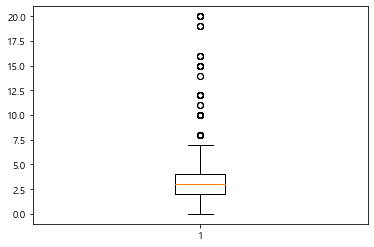

In [27]:
plt.boxplot([train['도보 10분거리 내 버스정류장 수']])
plt.show()

# 20에 가까운 값들이 존재하지만, 따로 처리해주기에는 독립적으로 떨어진 분포가 아니기 때문에, 제거하지 않는다.

In [28]:
display('Train Data')
display(X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))
display('='*50)
display('Test Data')
display(X_test.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))
display('='*50)
# 지하철 역 수가 3인 데이터는 제거한다.

display('After Engineering')
X_train = X_train[X_train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] != 3]
display(X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))

'Train Data'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    379
1.0     38
2.0      5
3.0      1
Name: 총세대수, dtype: int64

'=================================================='

'Test Data'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    139
1.0      8
2.0      3
Name: 총세대수, dtype: int64

'=================================================='

'After Engineering'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    379
1.0     38
2.0      5
Name: 총세대수, dtype: int64

## 3-2-1. Encoding

In [29]:
# 지역과 도보_지하철의 mean(평균), median(중간값) std(표준편차) 구하기

encoding_features = ['지역', '도보 10분거리 내 지하철역 수(환승노선 수 반영)']
for f in encoding_features:
    mapping = X_train.groupby([f])['등록차량수'].agg(['mean','median','std'])
    mapping_values = []
    for l in X_train[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_train.index)
    X_train = pd.concat([X_train,bincount], axis= 1).drop(columns = [f])

    mapping_values = []
    for l in X_test[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_test.index)
    X_test = pd.concat([X_test,bincount], axis= 1).drop(columns = [f])

In [30]:
# 2. 단위가 다르다.
## 총 세대수, 공가수는 "세대 수"를, "도보 ~~"는 근처의 "개수"를, "단지내주차면수"는 "면적"을 의미하는 등 의미하는 바가 다르다.
## 이 경우에는, Feature의 "Scale"을 동일하게 해주지 않으면 Machine Learning과정에서 가중치 학습에 있어서 오류가 있을 수 있다.
## 해결법 : Robust Scailing을 적용해준다. (Good for outliers)

scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '지역_mean', 
                     '지역_median',
                     '지역_std', 
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
                   '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
                   '도보 10분거리 내 지하철역 수(환승노선 수 반영)_std'
                    ]

AttributeError: 'Rectangle' object has no property 'title'

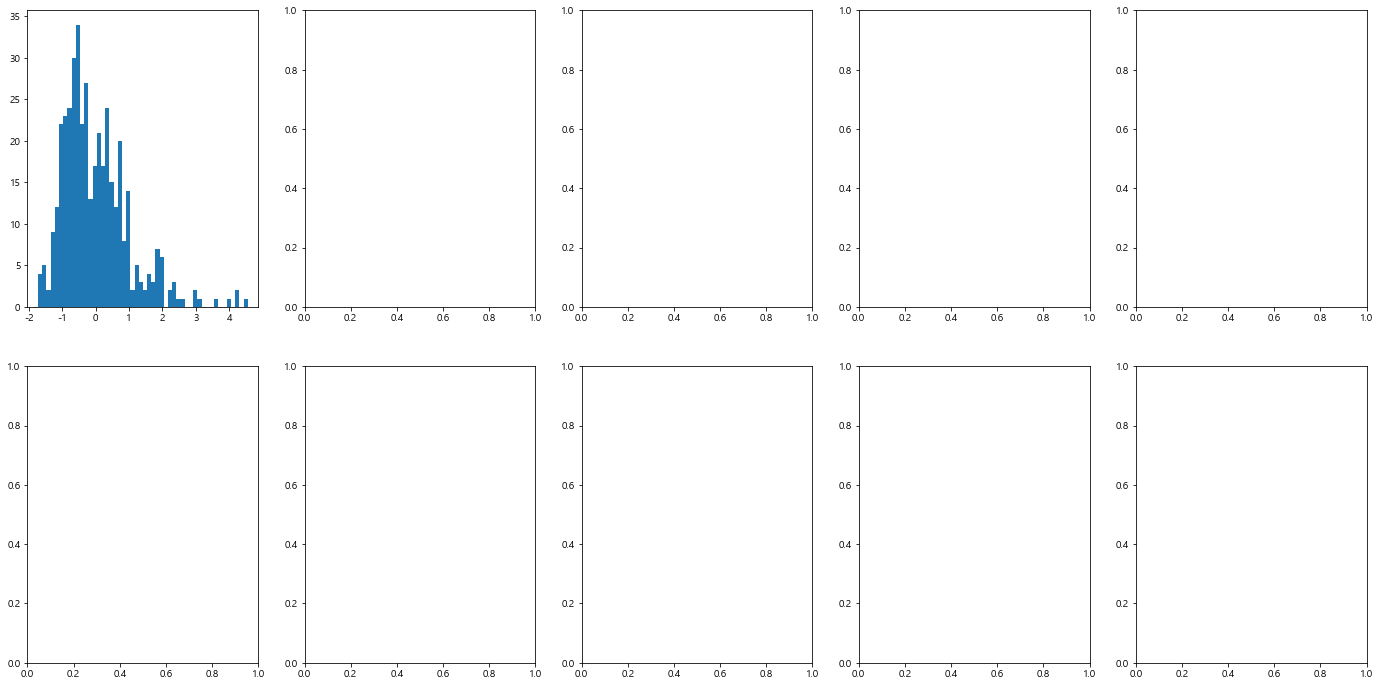

In [49]:
fig, axes = plt.subplots(2,5, figsize= (24,12))

i = 0
for f in scailing_features:  
    c = i % 5
    r = i // 5
    axes[r,c].hist(x = f, bins =50, data = X_train)
    i += 1
plt.show()


# 지역은 이상치가 확인 => Robust Scailing
# 도보 -> std 제거 
# 나머지는 Standard

In [32]:
# 도보 10분거리 std는 그림상 의미가 없기에 Drop
X_train = X_train.iloc[:,:-1]
X_test = X_test.iloc[:,:-1]

In [33]:
# 지역은  Robust Scailing

scaler = RobustScaler()
loc_f = [    '지역_mean', 
             '지역_median',
             '지역_std', ]
X_train.loc[:, loc_f] = scaler.fit_transform(X_train[loc_f])
X_test.loc[:, loc_f] = scaler.transform(X_test[loc_f])

## 3-2-2. Scailing

In [34]:
# 나머지 Standard Scailing
scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
                       '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
                    ]

scaler = StandardScaler()
X_train.loc[:, scailing_features] = scaler.fit_transform(X_train[scailing_features])
X_test.loc[:, scailing_features] = scaler.transform(X_test[scailing_features])

# 4. Modeling with pycaret

In [35]:
# pycaret은 setup 객체를 호출할 수 있다. 
# 이는 DataFrame으로 된 데이터를 Pycaret 각 머신러닝 기능 별로 사용할 수 있도록 전처리한다.

reg = setup(X_train, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            train_size = 0.999,  # 우리는 전체 데이터를 학습해 test를 예측하는게 목표이기 때문에, 0.999로 설정한다.
            target = '등록차량수', # 목표 변수는 등록 차량 수 이다.
            silent = True, # 엔터를 누르기 귀찮다. 궁금하면 풀어보세요
            use_gpu = False, # GPU가 있으면 사용하세요 (Cat BOost 속도 향상)
            numeric_features=list(X_train.drop(columns = ['등록차량수']).columns), # 모든 변수가 숫자로써의 의미가 있다.
            session_id = 2021,
            fold_shuffle = True
            )

,Description,Value
0,session_id,2021
1,Target,등록차량수
2,Original Data,"(422, 22)"
3,Missing Values,False
4,Numeric Features,21
5,Categorical Features,0
6,Transformed Train Set,"(421, 21)"
7,Transformed Test Set,"(1, 21)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


In [36]:
# top 5 모델 선택 
# compare_models : Setup 된 데이터를 각각 머신러닝 모델에 적용 후 비교한다.
# 평가산식 : MAE(Mean Absolute Error) 이므로 sorting MAE로 해서 확인
top5 = compare_models(n_select = 5, sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,125.1988,35508.2233,185.6443,0.7474,0.3896,0.3522,0.4330
huber,Huber Regressor,126.5474,33222.8912,179.8276,0.7673,0.4071,0.3645,0.0090
par,Passive Aggressive Regressor,126.9502,34187.2766,182.0227,0.7621,0.4418,0.3844,0.0050
br,Bayesian Ridge,127.7621,34035.5342,182.3251,0.7599,0.4352,0.3557,0.0050
llar,Lasso Least Angle Regression,127.9068,34727.1600,183.1723,0.7592,0.4076,0.3883,0.0040
ridge,Ridge Regression,127.9770,33995.0445,182.2432,0.7600,0.4410,0.3584,0.0050
lasso,Lasso Regression,128.0406,33796.4842,181.6456,0.7618,0.4290,0.3545,0.2070
lr,Linear Regression,128.8471,34048.5201,182.3509,0.7598,0.4525,0.3649,0.4510
gbr,Gradient Boosting Regressor,129.1675,36619.8012,189.2337,0.7361,0.3936,0.3443,0.0150
rf,Random Forest Regressor,129.1792,37307.4262,190.7672,0.7337,0.3714,0.3289,0.0560


In [37]:
# Top5 Model Tuning
# tune_model(): 데이터에 대한 머신러닝 모델의 파라미터 튜닝을 진행한다.
models = []
for m in top5:
    models.append(tune_model(m, 
                             optimize = 'MAE', 
                             choose_better = True,
                            n_iter = 30))
    
# MSE (Mean Squared Error) :회귀 모델의 주요 손실함수예측값과 실제값의 차이인 오차들의 제곱 평균으로 정의한다.제곱을 하기 때문에 특이치(아웃라이어)에 민감하다.
# MAE (Mean Absolute Error) : 실제값과 예측값의 차이인 오차들의 절댓값 평균, MSE보다는 특이치에 덜 민감하다.
# RMSE (Root Mean Squared Error) : MSE에 root를 씌운 값 오류 지표를 실제 값과 유사한 단위로 다시 변환하기에 해석이 다소 용이해진다.
# RMSLE (Root Mean Squared log Error) : 오차를 구할 때 RMSE와는 log를 추가하는 점이 다르다. . 아웃라이어에 덜 민감하다. (robust) : 아웃라이어가 있더라도 값의 변동폭이 크지 않다. 2. 상대적 Error를 측정해준다.
# R-Squared (결정계수) : 분산기반 예측 성능 평가 다른 MAE, MSE 등과 같은 지표들는 데이터의 scale에 따라 값이 다르지만
# MAPE (Mean Absolute Percentage Error) : MAE를 퍼센트로 변환, MAE와 같은 단점, 모델에 대한 편향이 존재

# 평가 지표
# 0에 가까울 수록 좋은 성능	MSE, MAE, RMSE, RMSLE, MAPE
# 1에 가까울 수록 좋은 성능	R-Squared

# 방법	Full	잔차 계산	이상치 영향
# MAE	Mean Absolute Error	Absolute Value	Yes
# MSE	Mean Squared Error	Square	No
# RMSE	Root Mean Squared Error	Square	No
# MAPE	Mean Absolute Percentage Error	Absolute Value	Yes
# MPE	Mean Percentage Error	N/A	Yes

# 참고자료 : https://mizykk.tistory.com/102

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,137.6469,37020.5844,192.4073,0.7481,0.4541,0.4438
1,128.0842,32811.2494,181.1388,0.7957,0.4916,0.4016
2,152.6469,41475.6046,203.6556,0.7335,0.4716,0.4308
3,128.6503,30093.5199,173.4748,0.8090,0.4945,0.2738
4,116.1587,22839.0281,151.1259,0.7900,0.3326,0.2772
5,142.9697,43961.5048,209.6700,0.7688,0.3738,0.3014
6,104.8039,24934.6609,157.9071,0.7802,0.3209,0.3180
7,146.0293,55390.1750,235.3512,0.7936,0.3172,0.2428
8,115.8168,29118.6280,170.6418,0.6757,0.3606,0.3342
9,100.0117,17240.6150,131.3035,0.7514,0.5026,0.5109


In [39]:
# 블랜딩 앙상블
voting = blend_models(models, optimize = 'MAE')
voting = tune_model(voting, 
                 optimize = 'MAE', 
                 choose_better = True,
                 n_iter = 30)

voting = finalize_model(voting)

# submission
sample = pd.read_csv('data/sample_submission.csv')
layer1_pred = voting.predict(X_test)
sample['num'] = layer1_pred
sample.to_csv('pycaret.csv', index=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,131.3620,31579.5497,177.7064,0.7851,0.4934,0.4960
1,120.9144,31772.0726,178.2472,0.8022,0.4308,0.3849
2,147.4441,40908.8371,202.2593,0.7371,0.4607,0.3936
3,121.6844,27506.1721,165.8498,0.8254,0.2777,0.2270
4,116.7563,21878.1826,147.9128,0.7988,0.3100,0.2655
5,137.3282,45210.3718,212.6273,0.7622,0.3628,0.2920
6,103.0668,24711.7057,157.1996,0.7822,0.3162,0.2723
7,140.4412,54139.8920,232.6798,0.7983,0.2746,0.2222
8,113.6496,29064.8440,170.4841,0.6763,0.3804,0.3500
9,95.6519,16668.3720,129.1060,0.7597,0.4951,0.5163


# 5. Modeling with CatBoostRegressor

In [40]:
# Setting Data For Model

X = X_train.drop(columns = ['등록차량수'])
y = X_train['등록차량수']

In [41]:
# Hyper params Tuning

def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": 42,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "verbose" : 1,
        "objective" : "MAE",
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)

    model = CatBoostRegressor(**params_cat)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False,
    )

    cat_pred = model.predict(X_val)
    log_score = mean_absolute_error(y_val, cat_pred)
    
    return log_score

In [42]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cat_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-07-30 13:59:20,687] A new study created in memory with name: cat_opt
[I 2021-07-30 13:59:20,992] Trial 0 finished with value: 123.26223800643668 and parameters: {'max_depth': 6, 'colsample_bylevel': 0.9901428612819833, 'subsample': 0.8123957592679836, 'min_child_samples': 62, 'max_bin': 246}. Best is trial 0 with value: 123.26223800643668.
[I 2021-07-30 13:59:21,136] Trial 1 finished with value: 113.0091990266325 and parameters: {'max_depth': 3, 'colsample_bylevel': 0.8116167224336399, 'subsample': 0.9063233020424546, 'min_child_samples': 62, 'max_bin': 413}. Best is trial 1 with value: 113.0091990266325.
[I 2021-07-30 13:59:21,268] Trial 2 finished with value: 114.4550583058736 and parameters: {'max_depth': 1, 'colsample_bylevel': 0.9939819704323989, 'subsample': 0.8827098485602951, 'min_child_samples': 25, 'max_bin': 254}. Best is trial 1 with value: 113.0091990266325.
[I 2021-07-30 13:59:21,411] Trial 3 finished with value: 141.9383308231626 and parameters: {'max_depth': 3, 

Best Score: 113.0091990266325
Best trial: {'max_depth': 3, 'colsample_bylevel': 0.8116167224336399, 'subsample': 0.9063233020424546, 'min_child_samples': 62, 'max_bin': 413}


In [43]:
cat_p = study.best_trial.params
cat = CatBoostRegressor(**cat_p)

In [44]:
# StratifiedK-Fold for Regression

y_cat = pd.cut(y, 10, labels=range(10))
skf = StratifiedKFold(5)

preds = []
for tr_id, val_id in skf.split(X, y_cat) : 
    X_tr = X.iloc[tr_id]
    y_tr = y.iloc[tr_id]
    
    cat.fit(X_tr, y_tr, verbose = 0)
    
    pred = cat.predict(X_test)
    preds.append(pred)
cat_pred = np.mean(preds, axis = 0)

In [46]:
# submission 

sample = pd.read_csv('data/sample_submission.csv')
sample['num'] = cat_pred
sample.to_csv('cat.csv', index=False)